In [1]:
!pip install torch-snippets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 113.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 M

In [2]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys
import os, os.path as osp


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp /content/drive/Shareddrives/MO434/dataset/project_dataset_corel.zip .
!unzip -q project_dataset_corel.zip

### Hyperparameters

In [5]:
batchsize = 32
n_class = 6
input_shape = (3,224,224)
device = torch.device('cuda')

lr = 2e-5
weight_decay=1e-4
n_epochs = 100

scheduler_step=20
scheduler_gamma = 0.5

dataset_dir = "/content/project_dataset_corel"

log_dir='/content/drive/Shareddrives/MO434/executions/cmk_net_classification_3_1'
best_model_path = osp.join(log_dir, 'best_model.pth')

try:
    os.makedirs(log_dir)
except FileExistsError:
    pass


### Define dataset

Training, validation

In [6]:
import cv2
from PIL import Image
import os, os.path as osp

def list_join_dir(dir):
    return sorted([osp.join(dir, f) for f in os.listdir(dir)])

class DataSet():
    def __init__(self, set_dir, class_red_circle=None, transforms=None) -> None:
        self.set_dir = set_dir
        self.transforms = transforms
        self.class_red_circle = class_red_circle

        self.img_dir = set_dir

        red_circle_dir = osp.join(osp.dirname(osp.abspath(self.set_dir)), 'red_circle')
        if self.class_red_circle is not None:
            red_circle_img = cv2.imread(osp.join(red_circle_dir, 'red_circle.png'), cv2.IMREAD_COLOR)
            mask = cv2.imread(osp.join(red_circle_dir, 'circle_mask.png'), cv2.IMREAD_GRAYSCALE)

        self.images, self.gts = [], []
        for img_path in list_join_dir(self.img_dir):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img_basename = osp.basename(img_path)
            class_id = int(img_basename.split('.')[0].split('_')[0])

            if self.class_red_circle is not None and self.class_red_circle == class_id:
                img = cv2.bitwise_and(img, img, mask=mask)
                img += red_circle_img

            self.images.append(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
            self.gts.append(class_id)
            cv2.imwrite

    def __getitem__(self, idx):
        if self.transforms:
            return self.transforms(self.images[idx]), self.gts[idx]
        return self.images[idx], self.gts[idx]

    def __len__(self):
        return len(self.images)


### Define transforms

In [7]:
from torchvision import transforms

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR,
                            fill=0),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #AddGaussianNoise(0, 0.1)
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

### Define dataloaders

In [8]:
from torch.utils.data import DataLoader

train_set = DataSet(osp.join(dataset_dir, 'train'), transforms=train_transforms)
val_set = DataSet(osp.join(dataset_dir, 'val'), transforms=val_transforms)

train_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

### Define CNN architecture

In [9]:
import torch
from torch import nn as nn
import math

class CMKNet(nn.Module):
    def __init__(self, dropout=0.5) -> None:
        super().__init__()

        self.dropout = dropout

        # input: 3, 224, 224
        self.col1 = nn.Sequential(
            self._conv_seq(3, 32, 3), # 32, 112, 112
            self._conv_seq(32, 64, 3), # 64, 56, 56
            self._conv_seq(64, 128, 3), # 128, 28, 28
        )

        #self.col2 = nn.Sequential(
        #    self._conv_seq(3, 24, 5), # 32, 112, 112
        #    self._conv_seq(24, 48, 5), # 64, 56, 56
        #    self._conv_seq(48, 96, 5), # 128, 28, 28
        #)

        #self.fuse = self._conv_seq(128+96, 32, 1) # 32, 14, 14
        #self.fuse = self._conv_seq(128, 32, 1) # 32, 14, 14

        self.classifier = nn.Sequential(
            self._linear_seq(128*28*28, 1024, dropout),
            self._linear_seq(1024, 256, dropout),
            nn.Linear(256, n_class)
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.col1(x)
        #x = self.fuse(torch.cat((x1, x2), 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _fuse(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def _linear_seq(self, in_features, out_features, dropout):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def _conv_seq(self, in_channels, out_channels, kernel_size):
        "conv2d, batchnorm, relu, max pool"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def _initialize_weights(self):
        #for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    #initialize bias with 0
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0
                    m.bias.data.zero_()


### Create the model

In [10]:
from torchsummary import summary

model = CMKNet().to(device)
summary(model,input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,432
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,728
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Linear-13                 [-1, 1024]     102,761,472
             ReLU-14                 [-

### Define the loss function, optimizer with L2 regularization and scheduler

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

### Define training and validation functions

In [12]:
def train_batch(model, data, optimizer, criterion, device):
    optimizer.zero_grad()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss = criterion(preds, targets)
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def validate(model, loader, criterion, device):
    #loader batchsize should be 1 for validation
    model.eval()
    rights = 0
    errors = 0
    cnt = len(loader)
    loss = 0
    for _, data in enumerate(loader):
        img, label = data
        img = img.to(device)
        label = label.to(device)
        pred = model(img)
        if torch.argmax(pred).item() == label.item():
            rights += 1
        else:
            errors += 1
        loss += criterion(pred, label)
    return loss/cnt, rights/cnt # average loss and accuracy


### Train the model and report the results

In [13]:
# initializing variables
log      = Report(n_epochs)
model.train()

best_model = None
best_model_loss = sys.maxsize

for epoch in range(n_epochs):
    N = len(train_loader)
    epoch_train_loss = 0
    for bx, data in enumerate(train_loader):
        loss = train_batch(model, data, optimizer, criterion, device)
        epoch_train_loss += loss

    loss, acc = validate(model, val_loader, criterion, device)
    if loss < best_model_loss:
        torch.save(model.state_dict(), best_model_path)
        best_model_loss = loss
        best_model = epoch

    log.record(epoch+1, train_loss=epoch_train_loss/N, val_loss=loss, val_acc=acc,
               best_model=best_model+1, best_loss=best_model_loss, end='\r')

    lr_scheduler.step()


EPOCH: 100.000  train_loss: 0.061  val_loss: 0.392  val_acc: 0.869  best_model: 74.000  best_loss: 0.381  (194.32s - 0.00s remaining)

### Plot the results

100%|██████████| 201/201 [00:00<00:00, 13858.52it/s]


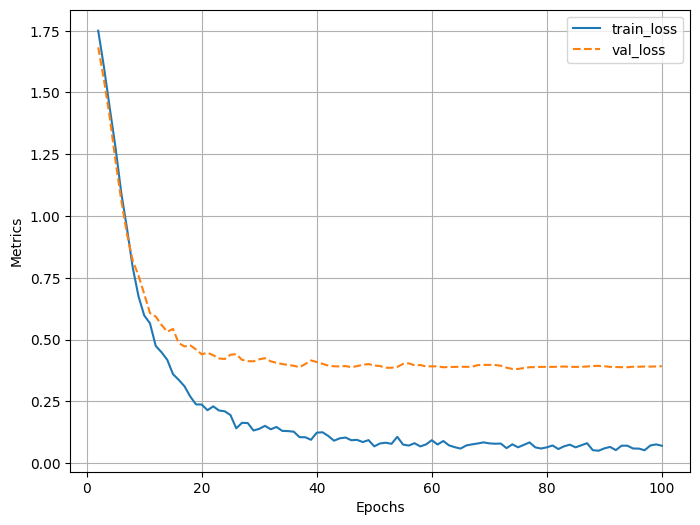

100%|██████████| 201/201 [00:00<00:00, 24624.81it/s]


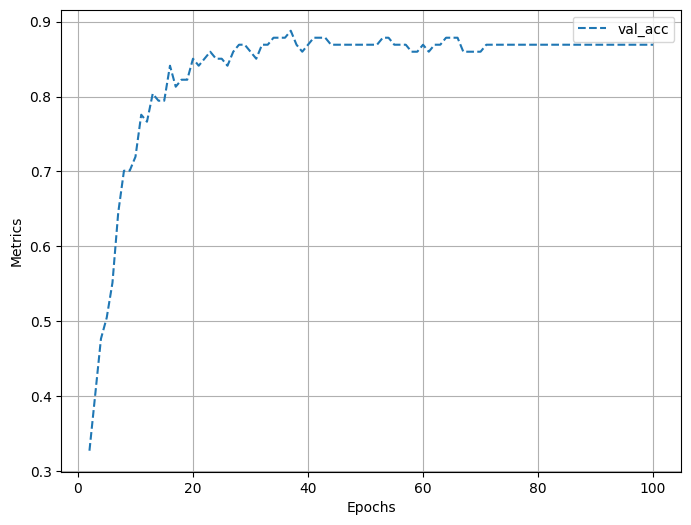

In [14]:
log.plot_epochs(['train_loss','val_loss'])
log.plot_epochs(['val_acc'])

### Evaluate the model

In [16]:
from sklearn import metrics
import numpy as np
import torch
import pandas as pd

@torch.no_grad()
def test(model, loader, criterion, device):
    #loader batchsize should be 1 for validation
    model.eval()
    preds, gts = [], []
    cnt = len(loader)
    loss = 0
    for _, data in enumerate(loader):
        img, label = data
        img = img.to(device)
        label = label.to(device)
        pred = model(img)
        preds.append(torch.argmax(pred).item())
        gts.append(label.item())
        loss += criterion(pred, label)
    return loss/cnt, preds, gts

def calculate_metrics(preds, gts):
    preds, gts = np.array(preds), np.array(gts)
    gen_acc = metrics.accuracy_score(gts, preds)
    gen_cohen_kappa = metrics.cohen_kappa_score(preds, gts)

    acc_per_class = []
    cohen_per_class = []

    n_class = gts.max() + 1

    for class_id in range(n_class):
        cohen_score = metrics.cohen_kappa_score(preds==class_id, gts==class_id)
        cohen_per_class.append(cohen_score)
        acc_score = metrics.accuracy_score(preds==class_id, gts==class_id)
        acc_per_class.append(acc_score)

    per_class_results = pd.DataFrame({
        'class': list(range(n_class)),
        'acc': acc_per_class,
        'cohen_kappa': cohen_per_class
    })
    return gen_acc, gen_cohen_kappa, per_class_results


#gen_acc, gen_cohen_kappa, per_class_r = calculate_metrics([0,1,2,2,3], [0,1,2,3,3])
#print(gen_acc, gen_cohen_kappa)
#print(per_class_r)

test_set = DataSet(osp.join(dataset_dir, 'test'), transforms=val_transforms)
test_loader  = DataLoader(test_set, batch_size=1, shuffle=False)

model = CMKNet()
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)

loss, preds, gts = test(model, test_loader, criterion, device)
gen_acc, gen_cohen_kappa, per_class_r = calculate_metrics(preds, gts)

result = f'Results \nAcc: {gen_acc:.4f}. cohen kappa: {gen_cohen_kappa:.4f}. Loss: {loss:.6f}'
print(result)

per_class_r.to_csv(osp.join(log_dir, 'per_class_result.csv'), index=False)

with open(osp.join(log_dir, 'results.txt'), 'w') as f:
    f.write(result)


Results 
Acc: 0.9057. cohen kappa: 0.8842. Loss: 0.220226